# 파이토치 CIFAR10 모델
- 코드 출처: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## modules import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

- 현재 GPU 설정

In [2]:
torch.cuda.is_available()

False

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
print(device)

cpu


## 전처리 설정

In [5]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

## 데이터 로드 및 확인

In [6]:
train_set = torchvision.datasets.CIFAR10(root = "./data",
                                         train=True,
                                         download=True,
                                         transform=transform)
test_set = torchvision.datasets.CIFAR10(root = "./data",
                                         train=False,
                                         download=True,
                                         transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True,num_workers=2)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True,num_workers=2)

In [8]:
classes = ("plane","car","bird","cat","deer",
           "dog","frog","horse","ship","truck")

In [9]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()


print(train_loader) 
print(list(train_loader)) 

dataiter = iter(train_loader)
images, labels = dataiter.next()#batch가 4니까 4개가 그려질 거임.

imshow(torchvision.utils.make_grid(images))
values = list((classes[labels[j]] for j in range(4)))
print(values)



KeyboardInterrupt: 

## 신경망 구성

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn. Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn. Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net().to(device)

## 손실함수와 옵티마이저

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 1e-3, momentum=0.9)

## 모델 학습

- 설명을 위해 `epochs=2`로 지정

In [42]:
from tqdm import tqdm

epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    # for i, data in tqdm(enumerate(train_loader,0)):
    for i, data in enumerate(train_loader,0):
        # print(i)
        optimizer.zero_grad()
        inputs, labels = data[0].to(device),data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()

        if i%2000==1999:
            print(f"epoch : {epoch} Batch: {i+1} Loss : {running_loss/2000}")
            running_loss=0.0

epoch : 0 Batch: 2000 Loss : 2.256800665020943
epoch : 0 Batch: 4000 Loss : 1.8952442987561227
epoch : 0 Batch: 6000 Loss : 1.6792176958024503
epoch : 0 Batch: 8000 Loss : 1.5967722882926465
epoch : 0 Batch: 10000 Loss : 1.531579729527235
epoch : 0 Batch: 12000 Loss : 1.4726209032908082
epoch : 1 Batch: 2000 Loss : 1.4138378037512302
epoch : 1 Batch: 4000 Loss : 1.367854745604098
epoch : 1 Batch: 6000 Loss : 1.3351743206456304
epoch : 1 Batch: 8000 Loss : 1.3150731195881962
epoch : 1 Batch: 10000 Loss : 1.29920071516186
epoch : 1 Batch: 12000 Loss : 1.2816931675896048


## 모델의 저장 및 로드

In [43]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(),PATH)

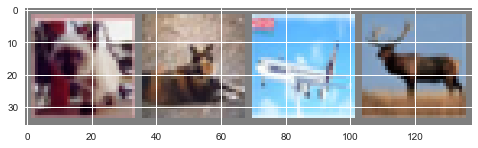

['cat', 'cat', 'plane', 'deer']


In [45]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
show_class = [classes[labels[i]] for i in range(4)]
print(show_class)

In [46]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트

In [50]:
outputs =net(images.to(device))


In [51]:
_, predicted = torch.max(outputs,1)
# print(predicted)
# print(" ".join(classes[predicted[j]] for j in range(4)))#dog bird plane deer
predict = [classes[v] for v in predicted]
print(predict) 

dog bird plane deer
['dog', 'bird', 'plane', 'deer']


In [55]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total +=labels.size(0)
        correct += (predicted==labels).sum().item()#맞춘 개수
        # correct += (predicted==labels).sum()#맞춘 개수 <- tensor(51.4900)

print(100*correct/total)

51.49


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [59]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
            
for i in range(10):
    print(f"Accuracy of {classes[i]}: {class_correct[i]/class_total[i]*100}% ")
    print(f"correct : {class_correct[i]} class_total {class_total[i]}")

Accuracy of plane: 54.2%
Accuracy of car: 54.400000000000006%
Accuracy of bird: 43.5%
Accuracy of cat: 22.0%
Accuracy of deer: 54.1%
Accuracy of dog: 46.400000000000006%
Accuracy of frog: 79.2%
Accuracy of horse: 27.3%
Accuracy of ship: 76.6%
Accuracy of truck: 57.199999999999996%
